Jasper Wilson
6/13/2022
Hearthstone Card Analysis

This is a small data-science project to demonstrate my abilities with common tools and processes. The aims of this project are to:
<ol>
    <li> Create a dataframe that includes all Hearthstone Cards and a value that we can associate with their strength</li>
    <li> Use https://rapidapi.com/omgvamp/api/hearthstone/ to get the full information for each card </li>
    <li> Create and normalize dataframe that includes basic features that could be relevant to a card's strength </li>
    <li> Use TensorFlow to create a neural network that can predict the strength of hypothetical cards </li>
</ol>
This project is unlikely to yield impactful results, since the strength of cards is tied to complex factors like card-specific text that will not be evaluated in this project. The goal of this project is to show my competence with data science tools. 

Lets start by importing some necessary libraries for this project.

In [231]:
#baisic tools
import re
import requests
import time
import math
import numpy as np
import pandas as pd

#scraping tools
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

#sklearn for dummy encoding
from sklearn.preprocessing import MultiLabelBinarizer

#tensorflow for training out network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#some minor visualization
import matplotlib.pyplot as plt
import seaborn as sns

The best indicator for the strength of individual cards is played rate (PR), which is the percentage of decks that contain a given card. This statistic can be found at https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes. So let's try scraping the information from this website. 

In [2]:
page = requests.get("https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes&type=MINION").text
soup = BeautifulSoup(page, 'html.parser')

Now that we have our page let's use BeutifulSoup to get a list of all the card names.

In [3]:
card_names = soup.find_all(class_='card-tile')
print(len(card_names))

0


Well that isn't right. It seems like this page loads the cards with JavaScript, so we need to use Selenium to load the page before we scrape it. 

In [4]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get('https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes&type=MINION')

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - About to download new driver from https://chromedriver.storage.googleapis.com/102.0.5005.61/chromedriver_linux64.zip
[WDM] - Driver has been saved in cache [/home/jaspermwilson/.wdm/drivers/chromedriver/linux64/102.0.5005.61]


WebDriverException: Message: unknown error: Chrome failed to start: exited abnormally.
  (unknown error: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /usr/bin/google-chrome is no longer running, so ChromeDriver is assuming that Chrome has crashed.)
Stacktrace:
#0 0x55c9c7cf3f33 <unknown>
#1 0x55c9c7a3e118 <unknown>
#2 0x55c9c7a61678 <unknown>
#3 0x55c9c7a5cd5a <unknown>
#4 0x55c9c7a97d3a <unknown>
#5 0x55c9c7a91e63 <unknown>
#6 0x55c9c7a6782a <unknown>
#7 0x55c9c7a68985 <unknown>
#8 0x55c9c7d384cd <unknown>
#9 0x55c9c7d3c5ec <unknown>
#10 0x55c9c7d2271e <unknown>
#11 0x55c9c7d3d238 <unknown>
#12 0x55c9c7d17870 <unknown>
#13 0x55c9c7d59608 <unknown>
#14 0x55c9c7d59788 <unknown>
#15 0x55c9c7d73f1d <unknown>
#16 0x7f176f66b609 <unknown>


That didn't work for me, so let's use the solution from https://stackoverflow.com/questions/53073411/selenium-webdriverexceptionchrome-failed-to-start-crashed-as-google-chrome-is. If the previous block didn't throw an error for you skip the next step.

In [ ]:
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome('/home/jaspermwilson/hs_deck_completion/chromedriver',chrome_options=chrome_options) #replace path here with path to chromedriver, see full details at https://chromedriver.chromium.org/getting-started
driver.get('https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes&type=MINION')

Alright now that we can read the JavaScript let's see how many cards we have now.

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html)
card_names = soup.find_all(class_='card-tile')
print(len(card_names))

That still isn't right. There should be well over 1000 cards on this page. Unfortunately these cards are loaded dynamically after the user scrolls. So let's take a solution from https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python to load all the cards. This code is inconsistent, loading the page may take a variable amount of time or hsreplay.net could refuse connection. Trying different pause times I was able to get all the cards and saved the output in text files.

In [ ]:
SCROLL_PAUSE_TIME = 2

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

#scroll down
driver.execute_script("window.scrollTo(0, 1000);")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

The following code blocks were used to generate the text-files to use for later use on 6/24/2022. If you want to generate new data un-comment this code, otherwise skip the next block.


In [2]:
html = driver.page_source
soup = BeautifulSoup(html)

card_names_soup = soup.find_all(class_='card-tile')
card_names_list = []
for i in card_names_soup:
    card_names_list.append(i['aria-label'])

with open('Card_Names.txt', 'w') as f:
    for line in card_names_list:
        f.write(line)
        f.write('\n')
    
statistics = soup.find_all('div', {'aria-describedby':re.compile('table1-row\S+ table1-column0')})
played_percent_list = []
for i in statistics:
    played_percent_list.append(i.text)

with open('Card_Played_Rate.txt', 'w') as f:
    for line in played_percent_list:
        f.write(line)
        f.write('\n')

NameError: name 'driver' is not defined

Get data from our text files, and make sure that the length and content looks right.

In [3]:
card_names_file = open("Card_Names.txt", "r")
card_names_data = card_names_file.read()
card_names_list = card_names_data.split("\n")
print(len(card_names_list))
print(card_names_list[0])

played_percent_file = open("Card_Played_Rate.txt", "r")
played_percent_data = played_percent_file.read()
played_percent_list = played_percent_data.split("\n")
print(len(played_percent_list))
print(played_percent_list[0])

2535
Zephrys the Great
2535
13.0%


These are one card too long since the last split returns an empty line, so we need to remove the last value from each list.

In [4]:
card_names_list.pop()
played_percent_list.pop()


''

Now let's make our dataframe.

In [5]:
df = pd.DataFrame()
df['Name'] = card_names_list
df['Inclusion Rate String'] = played_percent_list
df


,Name,Inclusion Rate String
0,Zephrys the Great,13.0%
1,Mutanus the Devourer,12.8%
2,Dirty Rat,10.9%
3,Brann Bronzebeard,10.6%
4,Blademaster Okani,9.6%
...,...,...
2529,Am'gam Rager,0%
2530,Air Elemental,0%
2531,Acidmaw,0%
2532,Abominable Bowman,0%


The inclusion rate is still a string, so let's convert it into a float and drop the string column.

In [6]:
df['Inclusion Rate'] = df['Inclusion Rate String'].str.rstrip('%').astype('float') / 100.0
df.drop('Inclusion Rate String', axis=1, inplace = True)
df

,Name,Inclusion Rate
0,Zephrys the Great,0.130
1,Mutanus the Devourer,0.128
2,Dirty Rat,0.109
3,Brann Bronzebeard,0.106
4,Blademaster Okani,0.096
...,...,...
2529,Am'gam Rager,0.000
2530,Air Elemental,0.000
2531,Acidmaw,0.000
2532,Abominable Bowman,0.000


Now we need to get the rest of our relevant information. My first attempt was to iterate through the dataframe and get the information, but this takes too long with the 1000+ api requests.

In [58]:
# def getCardType(card_name):
#     print(card_name)
#     formatted_name = card_name.replace(' ', '%20')
#     url = f"https://omgvamp-hearthstone-v1.p.rapidapi.com/cards/{formatted_name}"
    
#     querystring = {"collectible":"1"}

#     headers = {
#         "X-RapidAPI-Key": "64accc3c01msh8386ed44b3b00b7p1766a1jsna7ddde737a91",
#         "X-RapidAPI-Host": "omgvamp-hearthstone-v1.p.rapidapi.com"
#     }

#     response = requests.request("GET", url, headers=headers, params=querystring).json()

#     #should return a list of length 1
#     return(response[0]['type'])

# df['type_label'] = df.apply (lambda row: getCardType(row['Name']), axis=1)

Instead let's just get all the cards and work with the data locally.

In [7]:
url = "https://omgvamp-hearthstone-v1.p.rapidapi.com/cards"

querystring = {"collectible":"1"}

headers = {
    "X-RapidAPI-Key": "64accc3c01msh8386ed44b3b00b7p1766a1jsna7ddde737a91",
    "X-RapidAPI-Host": "omgvamp-hearthstone-v1.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring).json()


Now we have a complex json object that contains all the cards and their information, lets select all the sets we are interested in and combine them into one large dataframe. We can't use all sets because some are outdated and have different versions of the same card.

In [8]:
listOfSets = ['Core', 'Goblins vs Gnomes', 'The Grand Tournament', 'Whispers of the Old Gods', 'Mean Streets of Gadgetzan', 'Journey to Un\'Goro', 'Knights of the Frozen Throne', 'Kobolds & Catacombs', 'The Witchwood', 'The Boomsday Project', 'Rastakhan\'s Rumble', 'Rise of Shadows', 'Saviors of Uldum', 'Descent of Dragons', 'Ashes of Outland', 'Scholomance Academy', 'Forged in the Barrens', 'United in Stormwind', 'Fractured in Alterac Valley', 'Voyage to the Sunken City']
allCardsDF = pd.DataFrame()
for set in listOfSets:
    newDF = pd.DataFrame(response[set])
    allCardsDF = pd.concat([allCardsDF,newDF],ignore_index=True)
allCardsDF

,cardId,dbfId,name,cardSet,type,faction,rarity,cost,text,flavor,...,health,race,mechanics,durability,elite,armor,imgGold,multiClassGroup,classes,howToGetDiamond
0,CORE_CS2_072,69521,Backstab,Core,Spell,Neutral,Common,0,Deal $2 damage to an undamaged minion.,"It's funny how often yelling ""Look over there!...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CORE_EX1_169,69550,Innervate,Core,Spell,Neutral,Rare,0,Gain 1 Mana Crystal this turn only.,Some druids still have flashbacks from strange...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,1.0,Murloc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CORE_TRL_243,69689,Pounce,Core,Spell,NaN,Common,0,Give your hero +2_Attack this turn.,Comes with an overwhelming urge to jump into t...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CORE_EX1_145,69623,Preparation,Core,Spell,Neutral,Epic,0,The next spell you cast this turn costs (2) less.,"""Be Prepared"" - Rogue Motto",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,TID_077,76258,Lightray,Voyage to the Sunken City,Minion,NaN,Common,9,<b>Taunt</b>\nCosts (1) less for each Paladin ...,"Lightrays, much like rays of light, tend to be...",...,5.0,Elemental,[{'name': 'Taunt'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2933,TSC_659,74672,Trenchstalker,Voyage to the Sunken City,Minion,NaN,Epic,9,<b>Battlecry:</b> Attack three different rando...,Cooler heads prevail.,...,9.0,Beast,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2934,TID_712,75583,Neptulon the Tidehunter,Voyage to the Sunken City,Minion,NaN,Legendary,10,"[x]<b>Colossal +2</b>, <b>Rush</b>, <b>Windfur...","Neptulon, tired of filling hands, is now throw...",...,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",NaN,True,NaN,NaN,NaN,NaN,NaN
2935,TSC_061,73434,The Garden's Grace,Voyage to the Sunken City,Spell,NaN,Epic,10,[x]Give a minion +5/+5 and\n<b>Divine Shield</...,The perfect place to hold Conchella.,...,NaN,NaN,[{'name': 'Divine Shield'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at this table we can see a lot of NaNs. This is because different types of cards have different traits. All minions have attack and health, but no spells do. Instead of dropping NaNs or some of these features let's focus our analysis on only minions.

In [9]:
allMinionsDF = allCardsDF[allCardsDF['type'] == 'Minion']
allMinionsDF

,cardId,dbfId,name,cardSet,type,faction,rarity,cost,text,flavor,...,health,race,mechanics,durability,elite,armor,imgGold,multiClassGroup,classes,howToGetDiamond
2,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,1.0,Murloc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CORE_CS2_188,69649,Abusive Sergeant,Core,Minion,Alliance,Common,1,<b>Battlecry:</b> Give a minion +2_Attack this...,"ADD ME TO YOUR DECK, MAGGOT!",...,1.0,NaN,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CORE_KAR_009,69700,Babbling Book,Core,Minion,NaN,Rare,1,<b>Battlecry:</b> Add a random Mage spell to y...,"His idol is the Green Hills of Stranglethorn, ...",...,1.0,NaN,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,CORE_BT_351,69586,Battlefiend,Core,Minion,NaN,Common,1,"After your hero attacks, gain +1 Attack.",Say what you like about my hatchet-headed hool...,...,2.0,Demon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,CORE_ULD_191,76318,Beaming Sidekick,Core,Minion,NaN,Common,1,<b>Battlecry:</b> Give a friendly minion +2 He...,"Sure, I'll carry the water! And the food! And ...",...,2.0,NaN,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,TID_716,75635,Tidal Revenant,Voyage to the Sunken City,Minion,NaN,Common,8,<b>Battlecry:</b> Deal 5 damage. Gain 5 Armor.,A big minion that clears the board and gains A...,...,8.0,Elemental,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,TID_077,76258,Lightray,Voyage to the Sunken City,Minion,NaN,Common,9,<b>Taunt</b>\nCosts (1) less for each Paladin ...,"Lightrays, much like rays of light, tend to be...",...,5.0,Elemental,[{'name': 'Taunt'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2933,TSC_659,74672,Trenchstalker,Voyage to the Sunken City,Minion,NaN,Epic,9,<b>Battlecry:</b> Attack three different rando...,Cooler heads prevail.,...,9.0,Beast,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2934,TID_712,75583,Neptulon the Tidehunter,Voyage to the Sunken City,Minion,NaN,Legendary,10,"[x]<b>Colossal +2</b>, <b>Rush</b>, <b>Windfur...","Neptulon, tired of filling hands, is now throw...",...,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",NaN,True,NaN,NaN,NaN,NaN,NaN


Now we can do an inner join with our two dataframes to get our list of minions with a full set of features.


In [10]:
joinedDF = pd.merge(allMinionsDF, df, left_on='name', right_on='Name')
joinedDF

,cardId,dbfId,name,cardSet,type,faction,rarity,cost,text,flavor,...,mechanics,durability,elite,armor,imgGold,multiClassGroup,classes,howToGetDiamond,Name,Inclusion Rate
0,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murloc Tinyfin,0.0090
1,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murloc Tinyfin,0.0004
2,CORE_CS2_188,69649,Abusive Sergeant,Core,Minion,Alliance,Common,1,<b>Battlecry:</b> Give a minion +2_Attack this...,"ADD ME TO YOUR DECK, MAGGOT!",...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abusive Sergeant,0.0030
3,CORE_CS2_188,69649,Abusive Sergeant,Core,Minion,Alliance,Common,1,<b>Battlecry:</b> Give a minion +2_Attack this...,"ADD ME TO YOUR DECK, MAGGOT!",...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abusive Sergeant,0.0007
4,CORE_KAR_009,69700,Babbling Book,Core,Minion,NaN,Rare,1,<b>Battlecry:</b> Add a random Mage spell to y...,"His idol is the Green Hills of Stranglethorn, ...",...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Babbling Book,0.0090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,TID_716,75635,Tidal Revenant,Voyage to the Sunken City,Minion,NaN,Common,8,<b>Battlecry:</b> Deal 5 damage. Gain 5 Armor.,A big minion that clears the board and gains A...,...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tidal Revenant,0.0020
2179,TID_077,76258,Lightray,Voyage to the Sunken City,Minion,NaN,Common,9,<b>Taunt</b>\nCosts (1) less for each Paladin ...,"Lightrays, much like rays of light, tend to be...",...,[{'name': 'Taunt'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lightray,0.0030
2180,TSC_659,74672,Trenchstalker,Voyage to the Sunken City,Minion,NaN,Epic,9,<b>Battlecry:</b> Attack three different rando...,Cooler heads prevail.,...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trenchstalker,0.0008
2181,TID_712,75583,Neptulon the Tidehunter,Voyage to the Sunken City,Minion,NaN,Legendary,10,"[x]<b>Colossal +2</b>, <b>Rush</b>, <b>Windfur...","Neptulon, tired of filling hands, is now throw...",...,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",NaN,True,NaN,NaN,NaN,NaN,NaN,Neptulon the Tidehunter,0.0330


Alright we have a lot of features here so let's drop anything that seems irrelevant. This is the kind of decision that requries domain knowledge. None of these features are relevant to a cards PR.

In [11]:
joinedDF.drop(['name', 'cardId', 'dbfId', 'cardSet', 'type', 'faction', 'text', 'flavor', 'artist', 'collectible',
       'howToGet', 'howToGetGold', 'img', 'locale', 'spellSchool', 'classes',
        'durability', 'elite', 'armor',
       'imgGold', 'multiClassGroup', 'howToGetDiamond', 'Name',], axis=1, inplace=True)

In our group of remaining features we have 'mechanics' which is relevant, but is unfortunately a list of dictionaries because of how we interpreted our json response. We can fix this with a quick function that we can apply to our dataframe and convert each list of dictionaries into a list of items.

In [12]:
def convertDictsToList (row):
    newList = []
    if(isinstance(row['mechanics'], float)):
        return []
    for item in row['mechanics']:
        newList.append(item.get('name'))  
    return newList

joinedDF['mechanics_list'] = joinedDF.apply (lambda row: convertDictsToList(row), axis=1)
joinedDF

,rarity,cost,playerClass,attack,health,race,mechanics,Inclusion Rate,mechanics_list
0,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0090,[]
1,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0004,[]
2,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0030,[Battlecry]
3,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0007,[Battlecry]
4,Rare,1,Mage,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0090,[Battlecry]
...,...,...,...,...,...,...,...,...,...
2178,Common,8,Warrior,5.0,8.0,Elemental,[{'name': 'Battlecry'}],0.0020,[Battlecry]
2179,Common,9,Paladin,5.0,5.0,Elemental,[{'name': 'Taunt'}],0.0030,[Taunt]
2180,Epic,9,Warrior,8.0,9.0,Beast,[{'name': 'Battlecry'}],0.0008,[Battlecry]
2181,Legendary,10,Neutral,7.0,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",0.0330,"[Rush, Windfury, Colossal +X]"


Now that we have a list of items we can use dummy coding to convert this into several binary features that indicate whether or not a card has a certain mechanic. 

In [13]:
mlb = MultiLabelBinarizer(sparse_output=True)

joinedDF = joinedDF.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(joinedDF.pop('mechanics_list')),
                index=joinedDF.index,
                columns=mlb.classes_))
joinedDF


,rarity,cost,playerClass,attack,health,race,mechanics,Inclusion Rate,Adapt,AdjacentBuff,...,Recruit,Rush,Secret,Silence,Spell Damage,Spellburst,Stealth,Taunt,Tradeable,Windfury
0,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0090,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0004,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0030,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0007,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rare,1,Mage,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0090,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,Common,8,Warrior,5.0,8.0,Elemental,[{'name': 'Battlecry'}],0.0020,0,0,...,0,0,0,0,0,0,0,0,0,0
2179,Common,9,Paladin,5.0,5.0,Elemental,[{'name': 'Taunt'}],0.0030,0,0,...,0,0,0,0,0,0,0,1,0,0
2180,Epic,9,Warrior,8.0,9.0,Beast,[{'name': 'Battlecry'}],0.0008,0,0,...,0,0,0,0,0,0,0,0,0,0
2181,Legendary,10,Neutral,7.0,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",0.0330,0,0,...,0,1,0,0,0,0,0,0,0,1


Now lets convert the rest of our categorical variables into dummy encodings so that we can use all of our data for a linear regression. We also need to drop the 'mechanics' column since that isn't done automatically.

In [14]:
dummyDf = pd.get_dummies(joinedDF, prefix = ['rarity', 'playerClass', 'race'], columns = ['rarity', 'playerClass', 'race'])
dummyDf.drop(['mechanics'], axis=1, inplace=True)

Now we need to split our data into test and train data, we will use a standard 80-20 split. We also need to seperate our labels for evaluation.

In [15]:
train_data = dummyDf.sample(frac=0.8, random_state=0)
test_data = dummyDf.drop(train_data.index)

train_labels = train_data.pop('Inclusion Rate')
test_labels = test_data.pop('Inclusion Rate')

Now we need to normalize our data, let's use a tensorflow normilization layer.

In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_data)

2022-06-27 11:29:31.583205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 11:29:31.583242: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 11:29:31.583259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-ONVBKQ5): /proc/driver/nvidia/version does not exist
2022-06-27 11:29:31.585123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we can make and compile our model with the normilization layer and only one other layer to start with.

In [17]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

Now we can fit our model.

In [18]:
%%time
history = linear_model.fit(
    train_data,
    train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

CPU times: user 5.98 s, sys: 1.73 s, total: 7.71 s
Wall time: 3.81 s


To view how much our model improves over iterations we can use plotly along with history.

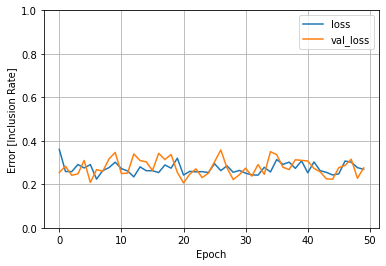

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Inclusion Rate]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

This looks bad, there is some decrease in error but it is still high at the end of training. Let's evaluate the total loss of our test data to see how our model performs before we take any more steps.

In [20]:
linear_model.evaluate(test_data, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 1760.4547


1760.4547119140625

This loss is super high. Clearly there is something wrong with our model. A likely culprit is overfitting. We have a lot of features, and not very many datapoints. So let's try a simple regression with only the very baisic features.

In [21]:
train_data_underfit = train_data[['cost', 'attack', 'health']]
test_data_underfit = test_data[['cost', 'attack', 'health']]

normalizer_underfit = tf.keras.layers.Normalization(axis=-1)
normalizer_underfit.adapt(train_data_underfit)

In [22]:
linear_model_underfit = tf.keras.Sequential([
    normalizer_underfit,
    layers.Dense(units=1)
])
linear_model_underfit.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

In [23]:
%%time
history = linear_model_underfit.fit(
    train_data_underfit,
    train_labels,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.94 s, sys: 1.68 s, total: 7.61 s
Wall time: 3.82 s


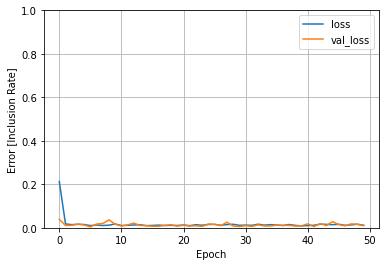

In [24]:
plot_loss(history)

In [25]:
linear_model_underfit.evaluate(test_data_underfit, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0106


0.010572249069809914

This simple model is a lot more accurate, but also less interesting. It won't tell us anything that a simple regression or common sense wouldn't. We need to figure out which of the complex features we want to continue to use. Let's get counts for each of our features so we can exclude any that might apply to only a few cards since those cases are most likely to lead to overfitting. For now let's exclude any features that are present fewer than 10 times. This leaves us with 57 features and our label.

In [26]:
counts = dummyDf.sum(axis=0)
slightlySmallerDF = dummyDf.drop(counts[counts < 10.0].index, axis=1)
slightlySmallerDF.columns

Index(['cost', 'attack', 'health', 'Inclusion Rate', 'Adapt', 'Aura',
       'Battlecry', 'Charge', 'Colossal +X', 'Combo', 'Deathrattle',
       'Discover', 'Divine Shield', 'Dormant', 'Dredge', 'Freeze', 'Frenzy',
       'Honorable Kill', 'Inspire', 'Lifesteal', 'Magnetic', 'Outcast',
       'Overload', 'Poisonous', 'Reborn', 'Rush', 'Secret', 'Silence',
       'Spell Damage', 'Spellburst', 'Stealth', 'Taunt', 'Windfury',
       'rarity_Common', 'rarity_Epic', 'rarity_Legendary', 'rarity_Rare',
       'playerClass_Demon Hunter', 'playerClass_Druid', 'playerClass_Hunter',
       'playerClass_Mage', 'playerClass_Neutral', 'playerClass_Paladin',
       'playerClass_Priest', 'playerClass_Rogue', 'playerClass_Shaman',
       'playerClass_Warlock', 'playerClass_Warrior', 'race_Beast',
       'race_Demon', 'race_Dragon', 'race_Elemental', 'race_Mech',
       'race_Murloc', 'race_Naga', 'race_Pirate', 'race_Quilboar',
       'race_Totem'],
      dtype='object')

Now let's train a model on this set of features.

In [232]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

In [28]:
s_normalizer = tf.keras.layers.Normalization(axis=-1)
s_normalizer.adapt(s_train_data)

In [29]:
s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

In [30]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

CPU times: user 5.97 s, sys: 1.88 s, total: 7.85 s
Wall time: 3.75 s


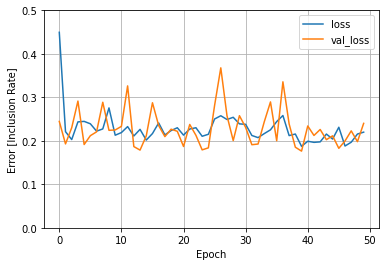

In [31]:
def plot_loss(s_history):
  plt.plot(s_history.history['loss'], label='loss')
  plt.plot(s_history.history['val_loss'], label='val_loss')
  plt.ylim([0, .5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Inclusion Rate]')
  plt.legend()
  plt.grid(True)

plot_loss(s_history)

In [32]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.2448


0.24484474956989288

This model does much better than our model with all the features, so the major source of our loss were the uncommon features. This model is still significantly worse than a model that uses only the most baisic features. Before we do any more feature engineering let's experiment with adding a hidden layer. Lets start by adding a hidden layer to our simple model.

In [35]:
train_data_underfit = train_data[['cost', 'attack', 'health']]
test_data_underfit = test_data[['cost', 'attack', 'health']]

normalizer_underfit.adapt(train_data_underfit)

linear_model_underfit = tf.keras.Sequential([
    normalizer_underfit,
    layers.Dense(units=2),
    layers.Dense(units=1)
])

linear_model_underfit.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 6.67 s, sys: 1.76 s, total: 8.43 s
Wall time: 4.2 s


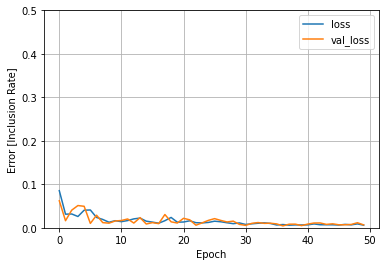

In [36]:
%%time
history = linear_model_underfit.fit(
    train_data_underfit,
    train_labels,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

In [37]:
linear_model_underfit.evaluate(test_data_underfit, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0073


0.007250058930367231

This model performs only slightly better than the same model with no hidden layer. This makes sense since this model is primitive. Our model with more features might benifit more from adding hidden layers. Lets start by adding one hidden layer.

In [41]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

s_normalizer.adapt(s_train_data)

s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=2),
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 7.21 s, sys: 2.34 s, total: 9.55 s
Wall time: 4.39 s


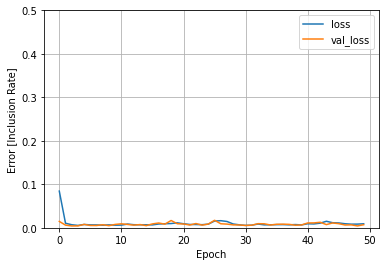

In [42]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history)

In [43]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0083


0.008276879787445068

After experimenting with different numbers of nodes it seeme like having two on the first hidden layer led to the best performance. This model is approaching the loss of our oversimplified model. Now we can try adding more layers to see if we can do even better. Let's start by adding a second hidden layer.

In [233]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

s_normalizer.adapt(s_train_data)

s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=5),
    layers.Dense(units=2),
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 24.7 s, sys: 1.88 s, total: 26.6 s
Wall time: 20.5 s


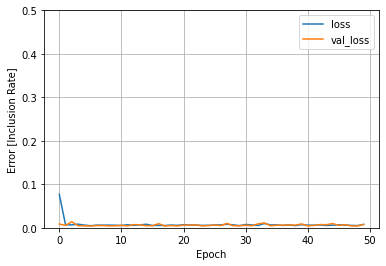

In [234]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history)

In [235]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.0084


0.008350662887096405

Adding a second layer consistentl improved performance. It is hard to say exactly how many nodes were optimal in this second layer but generally fewer than ten nodes worked best. Let's try adding a third layer and see if that improves our performance.

In [50]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

s_normalizer.adapt(s_train_data)

s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=15),
    layers.Dense(units=10),
    layers.Dense(units=2),
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 7.73 s, sys: 3.1 s, total: 10.8 s
Wall time: 4.77 s


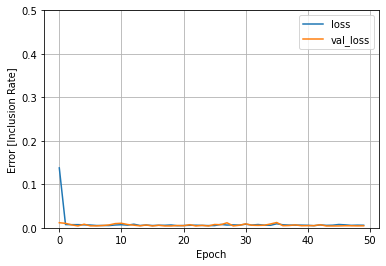

In [51]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history)

In [52]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0053


0.005317607894539833

Adding a third hidden layer doesn't seem to make any noticeable improvements, so let's stick with two layers. This finding aligns with contemporary ideas about the ideal number of hidden layers. I referenced this post to help make this decision: https://www.heatonresearch.com/2017/06/01/hidden-layers.html. Before we systematically optimize the number of nodes let's optimize our learning rate. Lets start with a broad spectrum of potential learning rates. Before we do this let's define a function for creating a model that returns it's testing loss.

In [191]:
def get_loss(layerOneCount, layerTwoCount, learningRate):
    s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
    s_test_data = slightlySmallerDF.drop(s_train_data.index)

    s_train_labels = s_train_data.pop('Inclusion Rate')
    s_test_labels = s_test_data.pop('Inclusion Rate')

    s_normalizer.adapt(s_train_data)
    
    s_linear_model = tf.keras.Sequential([
        s_normalizer,
        layers.Dense(units=layerTwoCount),
        layers.Dense(units=layerOneCount),
        layers.Dense(units=1)
    ])

    s_linear_model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learningRate),
        loss='mean_absolute_error')
    
    s_history = s_linear_model.fit(
        s_train_data,
        s_train_labels,
        epochs=100,
        verbose=0,
        validation_split = 0.2)
    
    return s_linear_model.evaluate(s_test_data, s_test_labels)

Now we can iterate model training to get an average loss for each learning rate. During testing I noticed a high variance in loss which is why I train each model configuration 20 times.

In [192]:
test_values = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
test_results = []
for i in test_values:
    total_loss = 0
    for k in range(20):
        total_loss += get_loss(2,3,i)
    test_results.append(total_loss)
    

14/14 [==============================] - 0s 2ms/step - loss: 0.0049


14/14 [==============================] - 0s 2ms/step - loss: 0.0949


In [193]:
test_results

[0.1548770978115499,
 0.09809745755046606,
 0.10062301298603415,
 0.1430985634215176,
 0.13978274166584015,
 0.2805155091919005,
 3.11143710790202]

It seems like our optimal rate is around 0.01 and 0.005. Lets do one more loop to zoom in on the optimal rate.

In [194]:
test_values = [0.03, 0.01, 0.007, 0.005, 0.003]
test_results = []
for i in test_values:
    total_loss = 0
    for k in range(20):
        total_loss += get_loss(2,3,i)
    test_results.append(total_loss)

14/14 [==============================] - 0s 1ms/step - loss: 0.0053


In [195]:
test_results

[0.12150609260424972,
 0.10164652997627854,
 0.09953085845336318,
 0.09952573198825121,
 0.10090772015973926]

So our optimal learning rate is 0.01. Now we need to optimize the number of nodes we want in each of our hidden layers. Based on my own observations the first later should have between 1-3 nodes. The second layer has a wider range of possible optimal values. This model doesn't take very much time to learn so let's try each value between 1-5.

In [196]:
results_df = pd.DataFrame(index=['1','2','3','4','5'], columns=['1','2','3'])
for i in range(3):
    for j in range(5):
        total_loss = 0
        for k in range(20):
            total_loss += get_loss(i+1, j+1, 0.005)
        results_df.iloc[j,i] = total_loss

14/14 [==============================] - 0s 2ms/step - loss: 0.0047


14/14 [==============================] - 0s 2ms/step - loss: 0.0047


14/14 [==============================] - 0s 3ms/step - loss: 0.0052


In [197]:
results_df

,1,2,3
1,0.09707,0.099113,0.103263
2,0.096317,0.100731,0.103853
3,0.096703,0.098627,0.099315
4,0.096517,0.099546,0.105452
5,0.095784,0.099244,0.102791


Let's use a heatmap to make trend in our results more obvious.

<AxesSubplot:>

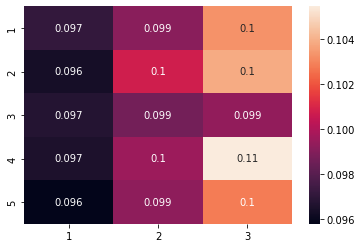

In [198]:
df = results_df.astype(float)

sns.heatmap(df, annot=True)


The results are close but the best performing configuration was 1,5 nodes in each hidden layer. So let's train a model with this configuration and make some predictions.
note: in other iterations I tested more than five nodes in the second layer and they performed worse. A subsequent iteration was run with the range between 1-5 so that I could train each model 20 times.

In [199]:
s_train_data_final = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data_final = slightlySmallerDF.drop(s_train_data_final.index)

s_train_labels_final = s_train_data_final.pop('Inclusion Rate')
s_test_labels_final = s_test_data_final.pop('Inclusion Rate')

s_normalizer.adapt(s_train_data_final)

s_linear_model_final = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=1),
    layers.Dense(units=5),
    layers.Dense(units=1)
])

s_linear_model_final.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

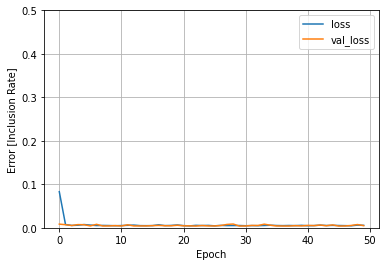

In [200]:
s_history_final = s_linear_model_final.fit(
    s_train_data_final,
    s_train_labels_final,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history_final)

This plot is a bit zoomed out so let's make another one with a smaller y limit.

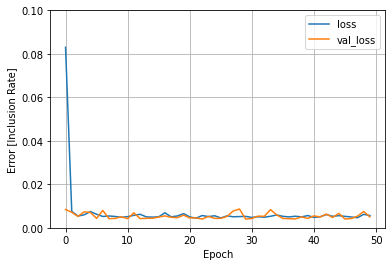

In [201]:
def plot_loss_mini(s_history):
  plt.plot(s_history.history['loss'], label='loss')
  plt.plot(s_history.history['val_loss'], label='val_loss')
  plt.ylim([0, .1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Inclusion Rate]')
  plt.legend()
  plt.grid(True)

plot_loss_mini(s_history_final)

In [202]:
s_linear_model_final.evaluate(s_test_data_final, s_test_labels_final)

14/14 [==============================] - 0s 1ms/step - loss: 0.0056


0.005636945832520723

Loss around .005 seems about right. This model looks good so let's try some hypothetical cards. Before we use any of our more complex features let's use our baisic features, the stats and cost of each card. Ideally a card has a high stats to cost ratio so let's try three examples and see if our model correctly asseses these cards. In adition to stats the only thing a card needs is a rarity so lets use the standard 'Rare' rarity just to be sure that all these examples could be real cards. See above for a full list of features in order.

In [223]:
sample = np.zeros([11,57])
#low cost high stats, should have an high PR
sample[0,0] = 0 #cost
sample[0,1] = 10 #attack
sample[0,2] = 10 #health
sample[0,36] = 1 #rarity = rare
#high cost high stats, should have a middling PR
sample[1,0] = 10
sample[1,1] = 10
sample[1,2] = 10
sample[1,36] = 1
#high cost low stats, should have a low PR
sample[2,0] = 10
sample[2,1] = 1
sample[2,2] = 1
sample[2,36] = 1

In [224]:
s_linear_model_final.predict(sample)

1/1 [==============================] - 0s 383ms/step


array([[0.00587534],
       [0.00605444],
       [0.00722372],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411]], dtype=float32)

Looking at the first three rows we can see that this model is not working as expected. It is making the opposite predictions about PR based on stats. The logical explination I can see for this is that most cards in Hearthstone aren't played for their raw stats, they are usually played because of the effects they have. Cards that are just stats with no effects exist, but they usually see very little play. So a model that has more information might correctly discern that cards that are over-statted see less play than under-statted cards with a powerful effect. Let's try contrasting it with our underfit model to see if it also makes incorrect predictions.

In [225]:
underfit_sample = np.zeros([3,3])
#low cost high stats, should have an high PR
underfit_sample[0,0] = 0
underfit_sample[0,1] = 10
underfit_sample[0,2] = 10
#high cost high stats, should have a middling PR
underfit_sample[1,0] = 10
underfit_sample[1,1] = 10
underfit_sample[1,2] = 10
#high cost low stats, should have a low PR
underfit_sample[2,0] = 10
underfit_sample[2,1] = 1
underfit_sample[2,2] = 1

linear_model_underfit.predict(underfit_sample)

1/1 [==============================] - 0s 361ms/step


array([[0.01021937],
       [0.00843859],
       [0.00509482]], dtype=float32)

So the model that only can access the information on stats and mana-cost does make the correct predictions here. If my previous hypothesis was true this woulnd't be the case. If higher statted cards had a lower PR this model should have the same results. Our first model must be minimizing the importance of stats and mana cost in favor of looking at key-words, and therefore makes incorrect predictions about stats when that is the only information it has. This tells us that a card's keywords are much more important than it's stats and mana-cost.

Since key words are important let's look at some types of keywords. One kind of keyword is a tribe. Tribes are strictly upgrades since it allows for synergy with other minions of the same tribe. Let's add two minions, one from the pirate tribe and one from the quilboar tribe. We expect both tribal minions to be higher than their non-tribal counterparts. In the current metagame pirates are better than quilboars, so we expect to see a higher PR for the pirate card.

In [226]:
#middle stats but let's make this minion a pirate
sample[3,0] = 10
sample[3,1] = 10
sample[3,2] = 10
sample[3,36] = 1
sample[3,49] = 10
#lets make another minion a quilboar
sample[4,0] = 10
sample[4,1] = 10
sample[4,2] = 10
sample[4,36] = 1
sample[4,50] = 10
s_linear_model_final.predict(sample)

1/1 [==============================] - 0s 329ms/step


array([[0.00587534],
       [0.00605444],
       [0.00722372],
       [0.00786533],
       [0.01084048],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411]], dtype=float32)

Looking ar rows 4 and 5 we see that our model predicts what we expect to see, both minions have a higher PR than the baseline and the pirate has a higher PR than the quillboar. 

Next let's look at keywords. Keywords are more complicated than tribes because they can be good or bad. However, they are generally good. The two keywords I want to look at are rush and deathrattle. Rush is a more powerful keyword, so we expect to see a rush minion to have a higher PR than a deathrattle minion.

In [227]:
#rush
sample[5,0] = 10
sample[5,1] = 10
sample[5,2] = 10
sample[5,36] = 1
sample[5,24] = 11
# deathrattle
sample[6,0] = 10
sample[6,1] = 10
sample[6,2] = 10
sample[6,36] = 1
sample[6,9] = 1
s_linear_model_final.predict(sample)

1/1 [==============================] - 0s 311ms/step


array([[0.00587534],
       [0.00605444],
       [0.00722372],
       [0.00786533],
       [0.01084048],
       [0.00859874],
       [0.00596065],
       [0.00731411],
       [0.00731411],
       [0.00731411],
       [0.00731411]], dtype=float32)

Looking at rows 6 and 7 we see our model predicts what we expect to see, with a fairly large difference between the two. Another difference between rush and deathrattle is that rush is stronger when the minion that posesses it is large. So a 10 mana rush minion with 10 attack and 10 health should be stronger than a 1 mana rush minion with 1 attack and 1 health. Deathrattle has nothing to do with stats so we shouldn't expect there to be any major interaction between having deathrattle and stats. So if our model is good a 1 mana minion with rush and a 1 mana minion with deathrattle should have much closer PRs than their 10 mana counterparts.

In [230]:
#rush
sample[7,0] = 1
sample[7,1] = 1
sample[7,2] = 1
sample[7,36] = 1
sample[7,24] = 1
# deathrattle
sample[8,0] = 1
sample[8,1] = 1
sample[8,2] = 1
sample[8,36] = 1
sample[8,9] = 1
s_linear_model_final.predict(sample)

1/1 [==============================] - 0s 287ms/step


array([[0.00587534],
       [0.00605444],
       [0.00722372],
       [0.00786533],
       [0.01084048],
       [0.00859874],
       [0.00596065],
       [0.00697309],
       [0.00696867],
       [0.00437512],
       [0.00444164]], dtype=float32)

Again our model predicts what I expected to see in rows eight and nine. I think this is the most impressive prediction since it shows an underlying connection between certain mechanics and stats. This relation would not exist in a simple regression and justifies the use of a neural network.

The last thing I want to investigate is what the model predicts about rarity. Legendary cards are more expensive than common cards, and generally more powerful. I cannot predict which will be more common. On one hand, legendary cards are more expensive so we should expet the cheaper cards to be more accessible and have a higher PR. On the other hand, there are lots of common cards that see zero play, so that might outweigh the cost factor. 

In [229]:
#common
sample[9,0] = 10
sample[9,1] = 10
sample[9,2] = 10
sample[9,33] = 1
#legendary
sample[10,0] = 10
sample[10,1] = 10
sample[10,2] = 10
sample[10,35] = 1
s_linear_model_final.predict(sample)

1/1 [==============================] - 0s 286ms/step


array([[0.00587534],
       [0.00605444],
       [0.00722372],
       [0.00786533],
       [0.01084048],
       [0.00859874],
       [0.00596065],
       [0.00711262],
       [0.00696867],
       [0.00437512],
       [0.00444164]], dtype=float32)

Looking at rows ten and eleven we can see that the PR is close for legendary and common cards. I think this is likely because of a balance between the factors I mentioned above. I think an analysis with less domain knowledge might assume that there is not a major difference in raw power between common and legendary cards, ignoring the importance of cost. This is a good example of how important domain knowledge is in analysis of data.

Overall I am satisfied with this project. I think other than raw statistics this model generally made intuitive predictions about card PR, and even gave some insight into a novel question (stength vs cost in a cards PR). Ultimately though, this model is still limited by two major factors. The first is that it does not take into account any of the card-specific text. Most cards have unique effects that go beyond just the keywords. Hypothetically this text could be analyzed with natural language processing. This brings us to our second issue, the size of our dataset. 2500 items is likely not large enough to enable us to use nlp to analyze card specific text. I am surprised that our model performed as well as it did considering the relivtively small size of the dataset. 
Although the majority of this notebook is dedicated to model construction, the most time-consuming portion was actually scraping the card PR data from hsreplay.net. I think this project shows that I am competent using TensorFlow, but I think it should really highlight my skill in data collection and processing. 
This project could be extended by including other types of cards(spells, weapons, heros) in my analysis. The reason they were not included in the current interation of this project is that they would introduce a significant number of new features without dramatically increasing the size of the dataset (there are many more minions than any other type of card). There is nothing that makes this analysis impossible, just like likely to be productive. I may extend this project in the future.